In [1]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from source.models.hidfmux.hidfmux_timestream import TimestreamData
from source.services.hidfmux_pkl_file_load_service import HidfmuxFileLoadService
from source.models.hidfmux.hidfmux_multi_sweep import HidfmuxMultiSweep
from source.util import noise_multiplication_method_tools
from source.models.noise.noise_sweep import NoiseSweep
from source.models.hidfmux.hidfmux_timestream import HidfmuxTimestream
from source.util import hidfmux_data_tools 
from source.util import hidfmux_transfer_functions
from netCDF4 import Dataset

from scipy.interpolate import CubicSpline



# Objectives:

1. Obtain tones list for channel 1 tones corresponding to each FBS:
    A. 45 degree polarisation.
    B. Vertical polarisation.
    C. Horizontal polarisation.
2. Plot spectra for each filter-bank
3. Extract statistics on f0s, Q's, yiel from each filter-bank.

# Data for first objective (FTS ):

SLIM_20_1_low
 - /export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/ts/slim_20_1_polgrid01.nc
 - /home/ice_user/ts/SLIM20/slim_20_1_polgrid01.txt 
 - chop temp = 800
 - chop freq = 5hz
 - multisweep = /export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/hidfmux_output/20240228/20240228_142942_multisweep/iceboard0147_rmod1/bias_find_multisweep_ampVARIOUS_npts150.pkl
  - picked_tones = /export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/hidfmux_output/20240228/20240228_142942_multisweep/iceboard0147_rmod1/picked_tones.npy

 
SLIM_20_1_high
 - /export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/ts/slim_20_1_polgrid02.nc
 - /home/ice_user/ts/SLIM20/slim_20_1_polgrid02.txt
 - near the end of this data I put a plate on the source side of the grid rotating aparatus to make sure no chopped signal was sneaking around the grid and into the detectors
 - chop temp = 800
 - chop freq = 5hz
 - multisweep = /export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/hidfmux_output/20240228/20240228_163848_multisweep/iceboard0147_rmod1/bias_find_multisweep_ampVARIOUS_npts150.pkl
 - picked_tones = /export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/hidfmux_output/20240228/20240228_163848_multisweep/iceboard0147_rmod1/picked_tones.npy


In [2]:
multi_sweep_path = r"/export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/hidfmux_output/20240228/20240228_142942_multisweep/iceboard0147_rmod1/bias_find_multisweep_ampVARIOUS_npts150.pkl"
timestream_path = r"/export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/ts/slim_20_1_polgrid01.nc"
dut = "slim20_v2_anl_channel_1"


In [3]:
multisweep_dictionary = np.load(
    multi_sweep_path,
    mmap_mode=None,
    allow_pickle=True,
    fix_imports=True,
    encoding="ASCII",
)

In [4]:
# Get best bias amplitudes and tone_names:
tone_name_array = np.array(multisweep_dictionary["info"]["name_list"])
(
    best_bias_amplitudes,
    bias_frequencies,
    no_bifurcation_tones
) = hidfmux_data_tools.get_best_multisweep_bias(multisweep_dictionary)
best_bias_indices = hidfmux_data_tools.get_best_bias_data_indices(
    bias_multisweep=multisweep_dictionary,
    best_bias_amplitudes=best_bias_amplitudes
)


In [5]:
# load multisweep using the best bias indices.
multisweep = HidfmuxFileLoadService.load_pkl_multi_sweep_file(multi_sweep_path, sweep_index=best_bias_indices)

In [6]:
# Check kid quality using own algorithm:
kid_quality_array = multisweep.get_good_kid_array(
        min_qr=1e3, max_qr=1e6, uncertainty_threshold=1.5, fit_fraction=0.8, plot_fits=False
    )

good_kid_indices = np.where(kid_quality_array == True)

Total good KIDs: 120
['0000' '0001' '0002' '0003' '0004' '0006' '0007' '0008' '0009' '0010'
 '0011' '0013' '0014' '0015' '0016' '0017' '0018' '0019' '0020' '0021'
 '0023' '0024' '0027' '0028' '0029' '0031' '0033' '0034' '0035' '0036'
 '0037' '0039' '0040' '0043' '0044' '0045' '0046' '0047' '0048' '0050'
 '0053' '0054' '0055' '0056' '0058' '0059' '0060' '0065' '0066' '0067'
 '0068' '0069' '0070' '0071' '0072' '0073' '0074' '0075' '0077' '0078'
 '0081' '0082' '0084' '0085' '0086' '0087' '0089' '0091' '0092' '0093'
 '0094' '0095' '0096' '0100' '0101' '0102' '0105' '0106' '0109' '0110'
 '0111' '0112' '0117' '0118' '0119' '0121' '0122' '0123' '0124' '0126'
 '0127' '0128' '0131' '0135' '0140' '0143' '0145' '0146' '0148' '0150'
 '0151' '0154' '0155' '0158' '0160' '0162' '0163' '0165' '0166' '0167'
 '0168' '0170' '0171' '0174' '0175' '0178' '0179' '0181' '0182' '0183']
Total No Peaks found: 17
['0005' '0042' '0083' '0088' '0090' '0107' '0108' '0116' '0120' '0125'
 '0136' '0137' '0149' '0152' '

In [7]:
# multisweep.plot_good_kids(kid_quality_array=kid_quality_array)

In [8]:
# Get list of the tones names that were used in measurements and their bias frequencies.
picked_tones_file = "/export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/hidfmux_output/20240228/20240228_142942_multisweep/iceboard0147_rmod1/picked_tones.npy"
picked_tones_dict = np.load(picked_tones_file, allow_pickle=True).tolist()
picked_tones = np.array([*picked_tones_dict.keys()])
picked_tone_frequencies = []
for tone in picked_tones:
    picked_tone_frequencies.append(picked_tones_dict[tone])

# Create kid quality array from the used tones
new_kid_quality_array = np.full(tone_name_array.shape, fill_value=False, dtype=bool)
picked_tone_name_indices = np.where(np.in1d(tone_name_array, picked_tones))[0]
new_kid_quality_array[picked_tone_name_indices] = True

picked_tone_amp_indices = best_bias_indices[picked_tone_name_indices]

In [9]:
# Plot the used (Green) and not used (red) tones: 
# multisweep.plot_good_kids(kid_quality_array=new_kid_quality_array)

In [10]:
timestream_data = Dataset(timestream_path,'r')


In [11]:
hidfmux_timestream = hidfmux_data_tools.create_hidfmux_timestream_from_ledgerman(
    timestream_data=timestream_data,
    tones_list=picked_tones[:5],
    tone_frequency_array=picked_tone_frequencies[:5],
    multisweep=multisweep
)

Tone 0000 Processed (0/4)
Tone 0001 Processed (1/4)
Tone 0002 Processed (2/4)
Tone 0003 Processed (3/4)
Tone 0004 Processed (4/4)


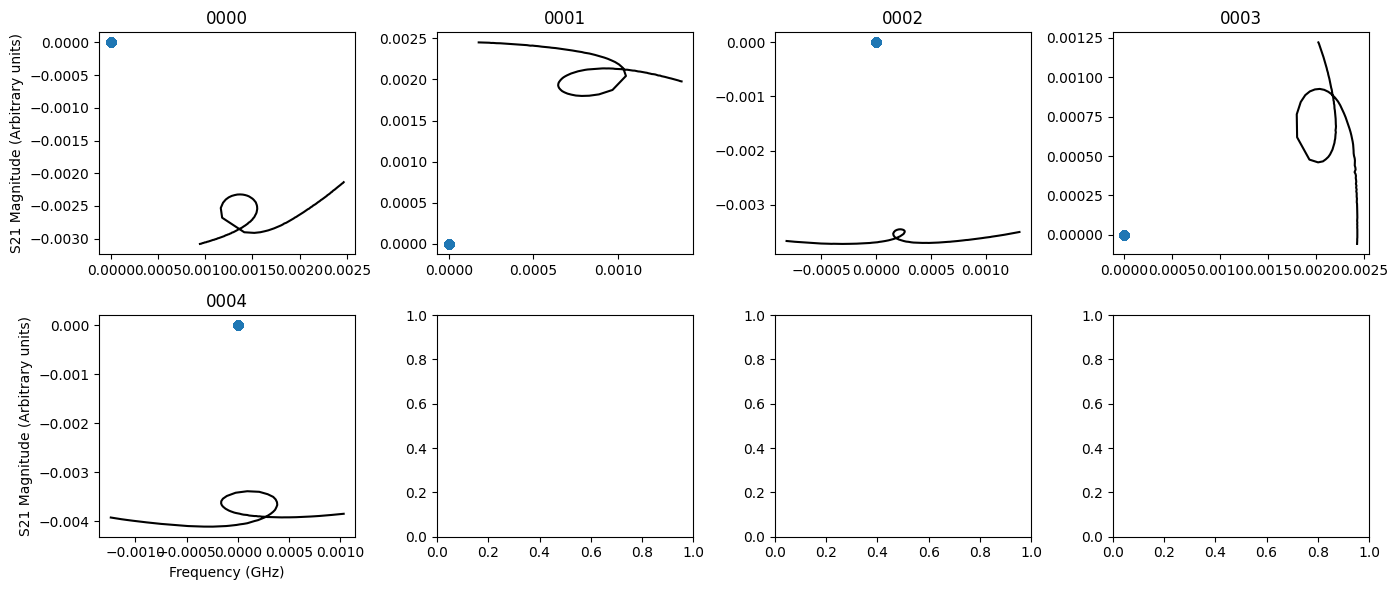

In [19]:
every_nth_value = 100

n_sweeps = hidfmux_timestream.tone_name_array.shape[0]
n_sweeps = 5
n_columns = 4
n_rows = math.ceil(n_sweeps / n_columns)

row = 0
column = 0
figures, axes = plt.subplots(n_rows, n_columns, figsize=(14, n_rows * 3))
for count, sweep in enumerate(hidfmux_timestream.sweep_data_array[:5]):
    current_timestream = hidfmux_timestream.get_tone_timestream_data(
        tone=hidfmux_timestream.tone_name_array[count],
        on_res=True
    )

    current_i = current_timestream.timestream_i_data[::every_nth_value] * hidfmux_transfer_functions.VOLTS_PER_ROC
    current_q = current_timestream.timestream_q_data[::every_nth_value] * hidfmux_transfer_functions.VOLTS_PER_ROC

    current_iq = current_i * 1.j*current_q
    current_iq = current_iq * np.exp(1.0j * np.pi * 1)

    current_i = current_iq.real
    current_q = current_iq.imag

    axes[row][column].plot(
        sweep.i, sweep.q, color="k"
    )
    axes[row][column].plot(
        current_i,
        current_q,
        linestyle="none",
        marker="o"
    )
    axes[row][column].set_title(
        hidfmux_timestream.tone_name_array[count]
    )

    if column == 0:
        axes[row][column].set_ylabel("S21 Magnitude (Arbitrary units)")

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Frequency (GHz)")

    column += 1
    if column == 4:
        column = 0
        row += 1
plt.tight_layout()
plt.show()

# Try plot data quality check on multisweep data. I think the sweep data from the hidfmux_timestream doesn't account for the phase noise thing.

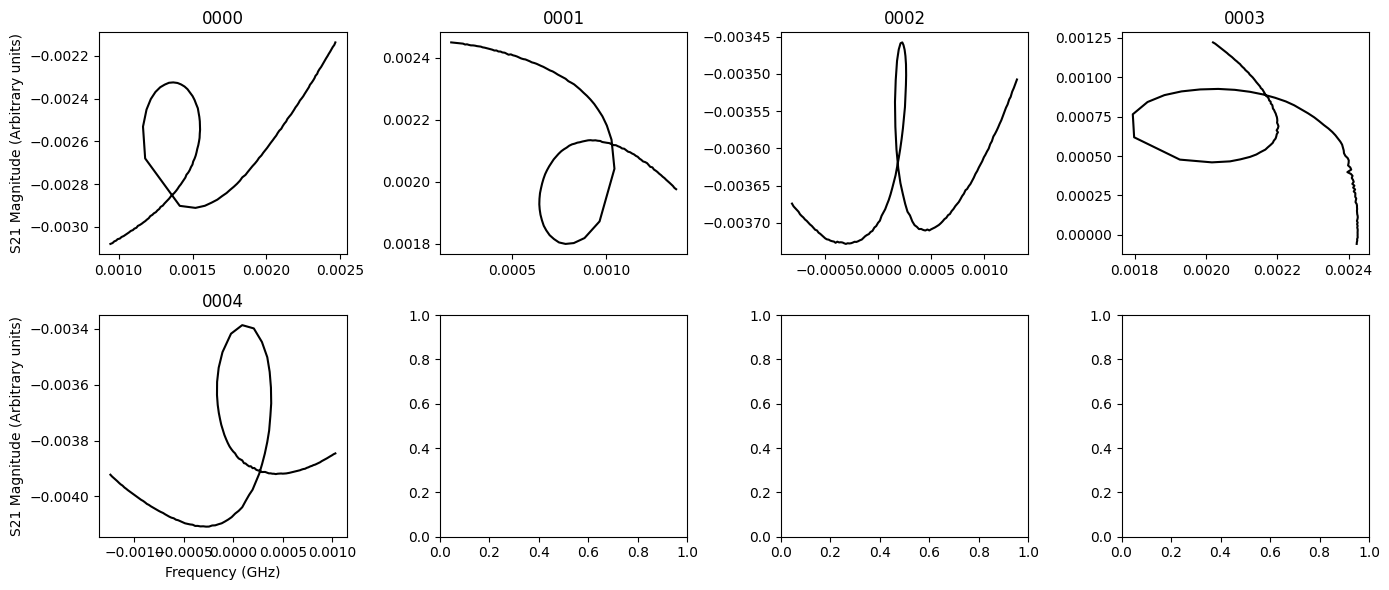

In [13]:
every_nth_value = 100

# n_sweeps = hidfmux_timestream.tone_name_array.shape[0]
n_sweeps = 5
n_columns = 4
n_rows = math.ceil(n_sweeps / n_columns)

row = 0
column = 0
figures, axes = plt.subplots(n_rows, n_columns, figsize=(14, n_rows * 3))
for count, sweep in enumerate(hidfmux_timestream.sweep_data_array[:5]):
    current_timestream = hidfmux_timestream.get_tone_timestream_data(
        tone=hidfmux_timestream.tone_name_array[count],
        on_res=True
    )
    axes[row][column].plot(
        sweep.i, sweep.q, color="k"
    )
    # axes[row][column].plot(
    #     current_timestream.timestream_i_data[::every_nth_value],
    #     current_timestream.timestream_q_data[::every_nth_value],
    #     linestyle="none",
    #     marker="o"
    # )
    axes[row][column].set_title(
        hidfmux_timestream.tone_name_array[count]
    )

    if column == 0:
        axes[row][column].set_ylabel("S21 Magnitude (Arbitrary units)")

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Frequency (GHz)")

    column += 1
    if column == 4:
        column = 0
        row += 1
plt.tight_layout()
plt.show()

In [14]:
#this calculates the total phase shift by which you need to multiply raw timestream data
#you have to do this or df will be garbage
#that tone better be within the sweep
def get_phase_correction_from_sweep(sdict, kid, latency, tone, amp_index=0):
	"""
	Description:

	ARGUMENTS
	---------


	RETURNS
	-------


	TODO
	----
	
	"""
	iq_adc = sdict['data'][kid][amp_index]['iq_raw']
	iq_cal = sdict['data'][kid][amp_index]['cal_iq']
	phi_internal = np.angle(iq_adc) - np.angle(iq_cal)

	freq = sdict['data'][kid][0]['freq']
	phi_latency = np.asarray([np.pi*(1. - (2*latency)*(f%(1./latency))) for f in freq])

	neg_phi_fpga = phi_internal - phi_latency

	#interpolate over the sweep (phase vs freq)
	interp_phase = CubicSpline(freq, neg_phi_fpga%(2*np.pi))
	neg_phase_correction = interp_phase(tone)
	return neg_phase_correction

In [15]:
#apply a phase correction to a raw timestream and also divide it by any data-packet-related constant
def correct_timestream_phase(iq_ts, neg_phase_correction, ts_mult_factor=1./256):
	"""
	Description:

	ARGUMENTS
	---------


	RETURNS
	-------


	TODO
	----
	
	"""
	iq_corr = np.abs(iq_ts*ts_mult_factor)*(np.cos(neg_phase_correction)+1.j*np.sin(neg_phase_correction))
	return iq_corr	

In [16]:
timestreams_array = np.empty(
    shape=picked_tones[:5].shape, dtype=object
)
bias_power_array = np.empty(
    shape=picked_tones[:5].shape, dtype=float,
)
sweep_data_array = np.empty(
    shape=picked_tones[:5].shape, dtype=object
)

for count, tone in enumerate(picked_tones[:5]):
    kid_i_raw = timestream_data.variables[tone+'_I'][:]
    kid_q_raw = timestream_data.variables[tone+'_Q'][:]

    kid_iq_raw = kid_i_raw+1j*kid_q_raw

    tone_frequency = picked_tone_frequencies[count]

    tone_bias_power = multisweep.get_tone_bias_power(
        tone=tone,
        db=False
    )
    # Get tone calibration sweep data to calibrate timestream IQ
    sweep_data = multisweep.get_tone_sweep_data(
        tone=tone
    )
    calibration_iq_array = multisweep.get_tone_calibration_iq_data(
        tone=tone
    )

    neg_phase_correction = get_phase_correction_from_sweep(
        sdict=multisweep_dictionary,
        kid=tone,
        tone=tone_frequency,
        latency=hidfmux_transfer_functions.DEMOD_SAMPLING_FREQ,
        amp_index=picked_tone_amp_indices[count]
    )

    kid_iq = correct_timestream_phase(kid_iq_raw, neg_phase_correction, ts_mult_factor=1)
    kid_i = np.real(kid_iq[15:]) # killing the first point which can be a very different value
    kid_q = np.imag(kid_iq[15:])

    time_array = np.array(timestream_data.variables["Time"][:])

    timestream = TimestreamData(
        n_timestreams=1,
        sample_rate=hidfmux_transfer_functions.DEMOD_SAMPLING_FREQ,
        measurement_length=time_array[-1] - time_array[0],
        tone_frequency=tone_frequency,
        timestream_i_data=kid_i,
        timestream_q_data=kid_q,
        timestream_time_data=time_array,
    )

    timestreams_array[count] = timestream
    bias_power_array[count] = tone_bias_power
    sweep_data_array[count] = sweep_data
    
    print(f"Tone {tone} Processed ({count + 1 }/{picked_tones[:5].size})")


test_hidfmux_timestream = HidfmuxTimestream(
    bias_power_array=bias_power_array,
    tone_name_array=picked_tones[:5],
    sweep_data_array=sweep_data_array,
    on_res_timestreams_array=timestreams_array,
    off_res_timestreams_array=timestreams_array,
)

Tone 0000 Processed (1/5)
Tone 0001 Processed (2/5)
Tone 0002 Processed (3/5)
Tone 0003 Processed (4/5)
Tone 0004 Processed (5/5)


sweep: 1.678E-03
TS: -4.507E-04
sweep: 7.854E-04
TS: 5.671E-04
sweep: 2.491E-04
TS: -6.118E-04
sweep: 2.237E-03
TS: 5.229E-04
sweep: -2.421E-05
TS: 2.935E-04


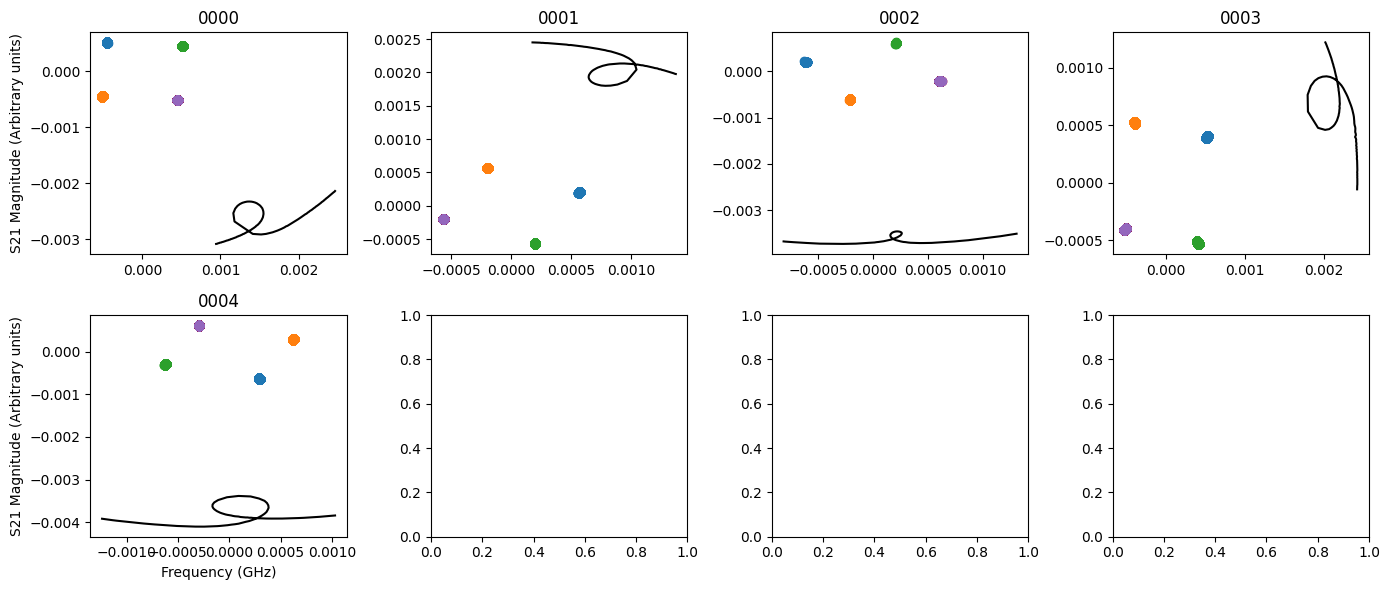

In [17]:
every_nth_value = 100

# n_sweeps = hidfmux_timestream.tone_name_array.shape[0]
n_sweeps = 5
n_columns = 4
n_rows = math.ceil(n_sweeps / n_columns)

row = 0
column = 0
figures, axes = plt.subplots(n_rows, n_columns, figsize=(14, n_rows * 3))
for count, sweep in enumerate(test_hidfmux_timestream.sweep_data_array[:5]):
    current_timestream = test_hidfmux_timestream.get_tone_timestream_data(
        tone=test_hidfmux_timestream.tone_name_array[count],
        on_res=True
    )
    current_i = current_timestream.timestream_i_data * hidfmux_transfer_functions.VOLTS_PER_ROC
    current_q = current_timestream.timestream_q_data * hidfmux_transfer_functions.VOLTS_PER_ROC

    print(f"sweep: {np.mean(sweep.i):.3E}")
    print(f"TS: {np.mean(current_i):.3E}")
    axes[row][column].plot(
        sweep.i, sweep.q, color="k"
    )

    rot_angle_array = np.linspace(0, 2, 5)

    for angle in rot_angle_array:
        current_iq = (current_i + 1j*current_q) * np.exp(1.0j*np.pi*angle)
        current_i = current_iq.real
        current_q = current_iq.imag

        axes[row][column].plot(
            current_i,
            current_q,
            linestyle="none",
            marker="o"
        )
    axes[row][column].set_title(
        hidfmux_timestream.tone_name_array[count]
    )

    if column == 0:
        axes[row][column].set_ylabel("S21 Magnitude (Arbitrary units)")

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Frequency (GHz)")

    column += 1
    if column == 4:
        column = 0
        row += 1
plt.tight_layout()
plt.show()

# Try plot data quality check on multisweep data. I think the sweep data from the hidfmux_timestream doesn't account for the phase noise thing.

In [18]:
test = test_hidfmux_timestream.get_tone_timestream_data("0000", True)
test.timestream_i_data

masked_array(data=[-3766.2923474549543, -3765.659126210615,
                   -3766.3746839276246, ..., -3798.247299509513,
                   -3797.530841743309, -3798.191373367429],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)